In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../src")

import yaml
from omegaconf import OmegaConf
file_path = "../config/whistle.yaml"
with open(file_path, 'r') as file:
    config = OmegaConf.create(yaml.safe_load(file))

import torch
import numpy as np
torch.manual_seed(config.seed)
np.random.seed(config.seed)

## Dataset

In [9]:
from data import WhistleDataset

dataset = WhistleDataset(config)
dataset.summarize()

DATA LOADED!

N Examples: 72154
N Classes: 2
Classes: [0. 1.]
 - Class 0: 55503 (76.92297031349614)
 - Class 1: 16651 (23.077029686503867)


## Model

In [10]:
from models import WhistleNet, CCNN
model = WhistleNet(config)
# model = CCNN(in_channels=1, out_channels=1, config=config)

## Training

In [11]:
from core.trainer import Trainer
trainer = Trainer(config)
# trainer.fit(model,dataset)

## Evaluation

In [12]:
import matplotlib.pyplot as plt

complete_plot = False
    
model.load()
model.evaluate(dataset)
plt.plot(model.test_scores, label='test scores')
plt.legend()
plt.ylabel('score')
plt.xlabel('epoch')
plt.show()

RuntimeError: Error(s) in loading state_dict for WhistleNet:
	Missing key(s) in state_dict: "conv.0.weight", "conv.0.bias", "conv.1.weight", "conv.1.bias", "conv.1.running_mean", "conv.1.running_var", "conv.5.weight", "conv.5.bias", "conv.6.weight", "conv.6.bias", "conv.6.running_mean", "conv.6.running_var", "conv.10.weight", "conv.10.bias", "conv.11.weight", "conv.11.bias", "conv.11.running_mean", "conv.11.running_var", "conv.15.weight", "conv.15.bias". 
	Unexpected key(s) in state_dict: "backbone.0.conv1.bias", "backbone.0.conv1.Kernel.kernel_net.0.bias", "backbone.0.conv1.Kernel.kernel_net.0.parametrizations.weight.original0", "backbone.0.conv1.Kernel.kernel_net.0.parametrizations.weight.original1", "backbone.0.conv1.Kernel.kernel_net.3.bias", "backbone.0.conv1.Kernel.kernel_net.3.parametrizations.weight.original0", "backbone.0.conv1.Kernel.kernel_net.3.parametrizations.weight.original1", "backbone.0.conv1.Kernel.kernel_net.6.bias", "backbone.0.conv1.Kernel.kernel_net.6.parametrizations.weight.original0", "backbone.0.conv1.Kernel.kernel_net.6.parametrizations.weight.original1", "backbone.0.conv2.bias", "backbone.0.conv2.Kernel.kernel_net.0.bias", "backbone.0.conv2.Kernel.kernel_net.0.parametrizations.weight.original0", "backbone.0.conv2.Kernel.kernel_net.0.parametrizations.weight.original1", "backbone.0.conv2.Kernel.kernel_net.3.bias", "backbone.0.conv2.Kernel.kernel_net.3.parametrizations.weight.original0", "backbone.0.conv2.Kernel.kernel_net.3.parametrizations.weight.original1", "backbone.0.conv2.Kernel.kernel_net.6.bias", "backbone.0.conv2.Kernel.kernel_net.6.parametrizations.weight.original0", "backbone.0.conv2.Kernel.kernel_net.6.parametrizations.weight.original1", "backbone.0.norm1.layer_norm.weight", "backbone.0.norm1.layer_norm.bias", "backbone.0.norm2.layer_norm.weight", "backbone.0.norm2.layer_norm.bias", "backbone.0.shortcut.0.weight", "backbone.0.shortcut.0.bias". 
	size mismatch for fc.0.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([1, 3520]).

## Inference on test audio

frame 0, time 0.00
Prediction: 0, elapsed: 0.0019
frame 1, time 0.02
Prediction: 0, elapsed: 0.0004
frame 2, time 0.05
Prediction: 0, elapsed: 0.0004
frame 3, time 0.07
Prediction: 0, elapsed: 0.0004
frame 4, time 0.09
Prediction: 0, elapsed: 0.0004
frame 5, time 0.12
Prediction: 0, elapsed: 0.0004
frame 6, time 0.14
Prediction: 0, elapsed: 0.0004
frame 7, time 0.16
Prediction: 0, elapsed: 0.0004
frame 8, time 0.19
Prediction: 0, elapsed: 0.0004
frame 9, time 0.21
Prediction: 0, elapsed: 0.0004
frame 10, time 0.23
Prediction: 0, elapsed: 0.0004
frame 11, time 0.26
Prediction: 0, elapsed: 0.0004
frame 12, time 0.28
Prediction: 0, elapsed: 0.0004
frame 13, time 0.30
Prediction: 0, elapsed: 0.0004
frame 14, time 0.33
Prediction: 0, elapsed: 0.0004
frame 15, time 0.35
Prediction: 0, elapsed: 0.0004
frame 16, time 0.37
Prediction: 0, elapsed: 0.0004
frame 17, time 0.39
Prediction: 0, elapsed: 0.0004
frame 18, time 0.42
Prediction: 0, elapsed: 0.0004
frame 19, time 0.44
Prediction: 0, elapse

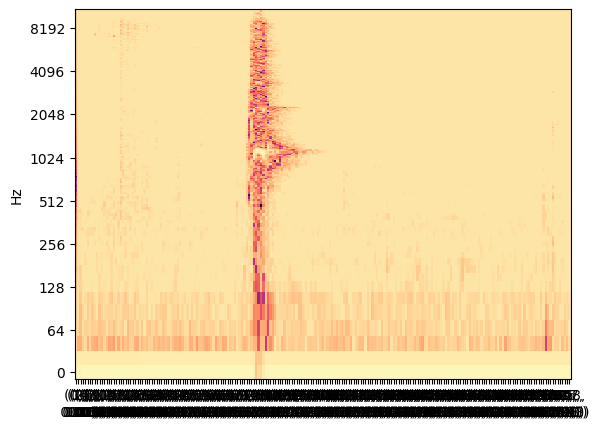

In [6]:
import torch
from utils import Audio, project_root
import time

def classify(window):
    with torch.no_grad():
        start = time.time()
        prediction = 1 if model(window) > 0.5 else 0
        elapsed = time.time() - start
        print(f"Prediction: {prediction}, elapsed: {elapsed:.4f}")
        return prediction


projroot = project_root()
audio = Audio(name="test2", datapath=f'{projroot}/data/whistle/raw/test')
for i in range(audio.S.shape[1]):
    window = torch.from_numpy(audio.S[:,i].reshape(1,1,513))
    print(f"frame {i}, time {audio.frame2time(i):.2f}")
    classify(window)
audio.freq_plot()

## Export to ONNX

In [7]:
import onnxscript, onnx

file = f"{projroot}/models/{model.name}/whistle.onnx"

torch.onnx.export(
    model,
    model.example_input[0],
    f = file,
    input_names=["input"],
    output_names=["output"],
)